In [139]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,cross_val_predict, KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, precision_score,recall_score, precision_recall_curve, f1_score, roc_curve, accuracy_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

import seaborn as sns

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import pickle
with open("df_bank.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [4]:
df.head()

,age,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,poutcome_nonexistent,poutcome_success,pdays_999,pdays_0_4,pdays_5_9,pdays_10_14,pdays_15_19,pdays_20_22,pdays_25_27,y
0,56,1,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,57,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,37,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,40,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,56,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


## 1. Baseline Models

In [131]:
features=list(df.columns.values)
features.remove('y')

X = df[features]
Y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

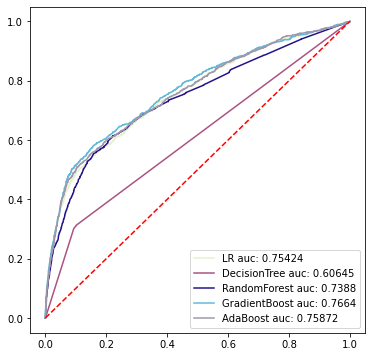

In [140]:
models=[(LogisticRegression(), 'LR'), (DecisionTreeClassifier(),'DecisionTree'),
        (RandomForestClassifier(),'RandomForest'),
        (GradientBoostingClassifier(),'GradientBoost'),(AdaBoostClassifier(),'AdaBoost')]

plt.figure(figsize=(6,6))
for model, model_label in models:
    scaler = StandardScaler()
    scaled_xtrain = scaler.fit_transform(X_train)
    scaled_xtest = scaler.transform(X_test)
    
    model.fit(scaled_xtrain, y_train)
    y_predict = model.predict_proba(scaled_xtest)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_predict)
    auc = roc_auc_score(y_test, y_predict)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label=model_label+ ' '+ 'auc: '+ str(round(auc,5)))
    

plt.plot([0,1],[0,1],'r--')
plt.legend()

In [135]:
models=[(LogisticRegression(), 'LR'),
        (DecisionTreeClassifier(),'DecisionTree'),(RandomForestClassifier(),'RandomForest'),
        (GradientBoostingClassifier(),'GradientBoost'),(AdaBoostClassifier(),'AdaBoost')]

#kf = KFold(n_splits=5, shuffle=True, random_state = 123)

for model, model_label in models:
    scaler = StandardScaler()
    scaled_xtrain = scaler.fit_transform(X_train)
    scaled_xtest = scaler.transform(X_test)
    model.fit(scaled_xtrain, y_train)
    
    y_predict_proba = model.predict_proba(scaled_xtest)[:,1]
    auc = roc_auc_score(y_test, y_predict_proba)
    y_predict = model.predict(scaled_xtest)

    print(model_label, 'auc:', auc)
    print('classification_report:\n',classification_report(y_test,y_predict))
    

LR auc: 0.7542439206535823
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94      7328
           1       0.62      0.17      0.26       910

    accuracy                           0.90      8238
   macro avg       0.76      0.58      0.60      8238
weighted avg       0.87      0.90      0.87      8238

DecisionTree auc: 0.6035890487787322
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      7328
           1       0.27      0.29      0.28       910

    accuracy                           0.84      8238
   macro avg       0.59      0.60      0.60      8238
weighted avg       0.84      0.84      0.84      8238

RandomForest auc: 0.7403729185661501
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7328
           1       0.50      0.24      0.32       910

    accur

## 2. Adjust balance between 2 outcomes

In [145]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


sm = SMOTE(random_state = 4)
X_train_res, y_train_res= sm.fit_sample(X_train, y_train)

scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train_res)
scaled_xtrain = pd.DataFrame(scaled_xtrain, columns=list(X_train.columns))
scaled_xtest = scaler.transform(X_test)

In [142]:
y_train_res.value_counts()

1    29220
0    29220
Name: y, dtype: int64

In [146]:
models=[(LogisticRegression(), 'LR'),
        (DecisionTreeClassifier(),'DecisionTree'),(RandomForestClassifier(),'RandomForest'),
        (GradientBoostingClassifier(),'GradientBoost'),(AdaBoostClassifier(),'AdaBoost')]

for model, model_label in models:
    model.fit(scaled_xtrain, y_train_res)
    y_predict_proba = model.predict_proba(scaled_xtest)[:,1]
    y_predict = model.predict(scaled_xtest)
    auc = roc_auc_score(y_test, y_predict_proba)
    print(model_label, ':', auc)
    print('classification_report:\n',classification_report(y_test,y_predict))

LR : 0.7533893031095542
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94      7328
           1       0.61      0.18      0.28       910

    accuracy                           0.90      8238
   macro avg       0.76      0.58      0.61      8238
weighted avg       0.87      0.90      0.87      8238

DecisionTree : 0.5996015583761217
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      7328
           1       0.26      0.30      0.27       910

    accuracy                           0.83      8238
   macro avg       0.58      0.59      0.59      8238
weighted avg       0.84      0.83      0.83      8238

RandomForest : 0.7465554369211573
classification_report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      7328
           1       0.43      0.30      0.36       910

    accuracy      

We trained models on balanced train set and test on test set -- increase in recall. auc remains similiar, accuracy decreases slightly.

## 3. Add Features: Social and Economic Attributes

In [147]:
with open("df_econ.pkl", 'rb') as picklefile: 
    df_econ = pickle.load(picklefile)

In [148]:
df_econ.head()

,age,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,pdays_10_14,pdays_15_19,pdays_20_22,pdays_25_27,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1.1,93.994,-36.4,4.857,5191.0,0


In [150]:
features=list(df_econ.columns.values)
features.remove('y')

X = df_econ[features]
Y = df_econ['y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

In [151]:
#oversample = SMOTE(sampling_strategy=0.3)
#X_over, Y_over = oversample.fit_resample(X_train, y_train)
#undersample = RandomUnderSampler(sampling_strategy=0.3)
#X_rs, Y_rs = undersample.fit_resample(X_over, Y_over)
sm = SMOTE(random_state = 4)
X_train_res, y_train_res= sm.fit_sample(X_train, y_train)

scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train_res)
scaled_xtrain = pd.DataFrame(scaled_xtrain, columns=list(X_train.columns))
scaled_xtest = scaler.transform(X_test)

In [153]:
models=[(LogisticRegression(), 'LR'),
        (DecisionTreeClassifier(),'DecisionTree'),(RandomForestClassifier(),'RandomForest'),
        (GradientBoostingClassifier(),'GradientBoost'),(AdaBoostClassifier(),'AdaBoost')]

for model, model_label in models:
    model.fit(scaled_xtrain, y_train_res)
    
    y_predict_proba = model.predict_proba(scaled_xtest)[:,1]
    y_predict = model.predict(scaled_xtest)
    auc = roc_auc_score(y_test, y_predict_proba)
    
    print(model_label, ':', auc)
    print('classification_report:\n',classification_report(y_test,y_predict))
    

LR : 0.7853962972071598
classification_report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7328
           1       0.60      0.22      0.32       910

    accuracy                           0.90      8238
   macro avg       0.76      0.60      0.63      8238
weighted avg       0.88      0.90      0.88      8238

DecisionTree : 0.6229791496712894
classification_report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      7328
           1       0.30      0.34      0.32       910

    accuracy                           0.84      8238
   macro avg       0.61      0.62      0.61      8238
weighted avg       0.85      0.84      0.84      8238

RandomForest : 0.7667466199193821
classification_report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7328
           1       0.50      0.35      0.41       910

    accuracy      

##### We see increases in auc scores and recall ---- new features are helpful

## 4. Parameter Tuning with validation

In [159]:
def model_print_scores(model_label, model):
    pipeline =imbPipeline([
        ("smote", SMOTE()),
        ("standardscaler", StandardScaler()),
        ( model_label, model)
    ])
    kf = StratifiedKFold(n_splits=5, random_state = 89)
    scoring = ['accuracy','roc_auc','f1','precision','recall']
    scores = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=scoring)
    print(model_label, 'Accuracy:', scores['test_accuracy'].mean())
    print(model_label, 'AUC:', scores['test_roc_auc'].mean())
    print(model_label, 'Precision', scores['test_precision'].mean())
    print(model_label, 'Recall', scores['test_recall'].mean())
    print(model_label, 'F1', scores['test_f1'].mean())

### 1. Logistic

In [286]:
log_pipe = imbPipeline([
    ("smote", SMOTE()),
    ("standardscaler", StandardScaler()),
    ("logisticregression", LogisticRegression())
])

log_param = {'logisticregression__penalty':['l1', 'l2'],
             'logisticregression__C':[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000]}

kf = StratifiedKFold(n_splits=5, random_state = 89)

#scoring=['roc_auc', 'recall', 'f1','accuracy']

#scorers = {
#    'precision_score': make_scorer(precision_score),
#    'recall_score': make_scorer(recall_score),
#    'accuracy_score': make_scorer(accuracy_score)}
#log_grid = GridSearchCV(log_pipe, log_param, cv=kf, scoring=scorers, refit='recall_score')
log_grid = GridSearchCV(log_pipe, log_param, cv=kf, scoring='recall')
log_grid.fit(X_train, y_train)

log_grid.best_params_

{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}

In [278]:
#log_grid.cv_results_

In [161]:
model_print_scores("logisticregression", LogisticRegression(C=0.001, penalty='l2'))

logisticregression Accuracy: 0.8942033383915022
logisticregression AUC: 0.7856606441289433
logisticregression Precision 0.5538422048576326
logisticregression Recall 0.3367292225201072
logisticregression F1 0.4186121589958584


### 2. DecisionTree

In [301]:
dt_pipe = imbPipeline([("smote", SMOTE()),("standardscaler", StandardScaler()),
                            ("decisiontreeclassifier", DecisionTreeClassifier())])
dt_params={'decisiontreeclassifier__min_samples_split': [10,25,50,100,150,200,300,400,500,600,800,1000,1200,1500,2000],
           'decisiontreeclassifier__min_samples_leaf':[1, 2, 5, 10,20,50,100,200]}

kf = StratifiedKFold(n_splits=5, random_state = 89)

dt_grid = GridSearchCV(dt_pipe, dt_params, cv=kf, scoring='recall')
dt_grid.fit(X_train, y_train)

dt_grid.best_params_

{'decisiontreeclassifier__min_samples_leaf': 20,
 'decisiontreeclassifier__min_samples_split': 2000}

In [162]:
model_print_scores("decisiontree", DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=2000))

decisiontree Accuracy: 0.8548103186646433
decisiontree AUC: 0.7691495872121082
decisiontree Precision 0.401972152293422
decisiontree Recall 0.5506702412868634
decisiontree F1 0.4630711888855565


### 3. RandomForest

In [327]:
rf_pipe = imbPipeline([("smote", SMOTE()),("standardscaler", StandardScaler()),
                            ("randomforestclassifier", RandomForestClassifier())])

rf_params={'randomforestclassifier__n_estimators' : [100,500,300,1000],
           'randomforestclassifier__max_features' : ['sqrt', 'none', 'log2'],
          'randomforestclassifier__min_samples_leaf' : [2, 10, 25, 50,75,100,125,150]}

kf = StratifiedKFold(n_splits=5, random_state = 89)

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=kf, scoring='recall',n_jobs=-1)
rf_grid.fit(X_train, y_train)

rf_grid.best_params_

{'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__min_samples_leaf': 150,
 'randomforestclassifier__n_estimators': 500}

In [163]:
model_print_scores("RF", RandomForestClassifier(max_features='log2',min_samples_leaf=150, n_estimators=500))

RF Accuracy: 0.8559635811836115
RF AUC: 0.7895319642244377
RF Precision 0.4072134325469846
RF Recall 0.5973190348525469
RF F1 0.484203918026913


### 4. GradientBoostingClassifier()

In [322]:
gb_pipe = imbPipeline([("smote", SMOTE()),("standardscaler", StandardScaler()),
                            ("gradientboostingclassifier", GradientBoostingClassifier())])

gb_params = {'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
             'gradientboostingclassifier__n_estimators':range(20,151,10)}

kf = StratifiedKFold(n_splits=5, random_state = 89)

gb_grid = GridSearchCV(gb_pipe, gb_params, cv=kf, scoring='recall')
gb_grid.fit(X_train, y_train)

gb_grid.best_params_

{'gradientboostingclassifier__learning_rate': 0.05,
 'gradientboostingclassifier__n_estimators': 20}

In [164]:
model_print_scores("GB", GradientBoostingClassifier(learning_rate=0.05,n_estimators=20))

GB Accuracy: 0.8531411229135053
GB AUC: 0.7828523285494347
GB Precision 0.39899153722850916
GB Recall 0.5860589812332441
GB F1 0.4745321496392295


In [324]:
gb_pipe2 = imbPipeline([("smote", SMOTE()),("standardscaler", StandardScaler()),
                            ("gradientboostingclassifier", GradientBoostingClassifier(learning_rate=0.05,n_estimators=20))])

gb_params2 = {'gradientboostingclassifier__max_depth':range(5,16,2), 
              'gradientboostingclassifier__min_samples_split':range(200,1001,200)}

gb_grid2 = GridSearchCV(gb_pipe2, gb_params2, cv=kf, scoring='recall')
gb_grid2.fit(X_train, y_train)

gb_grid2.best_params_

{'gradientboostingclassifier__max_depth': 5,
 'gradientboostingclassifier__min_samples_split': 800}

In [165]:
model_print_scores("GB", GradientBoostingClassifier(learning_rate=0.05,n_estimators=20,max_depth=5,min_samples_split= 800))

GB Accuracy: 0.8695902883156297
GB AUC: 0.784285433789703
GB Precision 0.4393127239812217
GB Recall 0.5482573726541554
GB F1 0.4873704286806378


### 5. AdaBoostClassifier()

In [334]:
ada_pipe = imbPipeline([("smote", SMOTE()),("standardscaler", StandardScaler()),
                            ("adaboostclassifier", AdaBoostClassifier())])

ada_params = {'adaboostclassifier__n_estimators': [25,50,75,100,150,200,300,400],
              'adaboostclassifier__learning_rate': [0.0001, 0.001,0.01, 0.05, 0.1, 0.5, 1]}

kf = StratifiedKFold(n_splits=5, random_state = 89)

ada_grid = GridSearchCV(ada_pipe, ada_params, cv=kf, scoring='recall')
ada_grid.fit(X_train, y_train)

ada_grid.best_params_

{'adaboostclassifier__learning_rate': 0.05,
 'adaboostclassifier__n_estimators': 25}

In [166]:
model_print_scores("Ada", AdaBoostClassifier(learning_rate=0.05,n_estimators=25))

Ada Accuracy: 0.7581487101669196
Ada AUC: 0.7719528564848711
Ada Precision 0.27363961801396464
Ada Recall 0.68686327077748
Ada F1 0.3913587120267327


#### AdaBoost gives the best recall, with RandomForest as the second best. Their auc scores are very similar, but Ada has lower accuracy, precision and F1 scores (since it predicts many 0 as 1, high false positive). 

##### Depends on the marketing budget, if the bank is eager to seize all positive subscriber, we'll go with AdaBoost. If the budget is limited, we can go with RandomForest.

## 4. Recall Threshold

divide train set to have train and validation

In [10]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=40)

In [11]:
sm = SMOTE(random_state = 8)
X_train_res, y_train_res= sm.fit_sample(X_train2, y_train2)
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train_res)
scaled_xtrain = pd.DataFrame(scaled_xtrain, columns=list(X_train.columns))
scaled_xtest = scaler.transform(X_val)

#### RandomForest

AUC 0.795260077141106
classification_report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      5826
           1       0.39      0.60      0.48       764

    accuracy                           0.85      6590
   macro avg       0.67      0.74      0.69      6590
weighted avg       0.88      0.85      0.86      6590



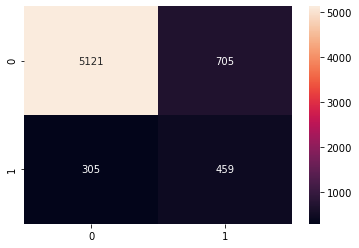

In [122]:
rf_model=RandomForestClassifier(max_features='log2',min_samples_leaf=150, n_estimators=500)
rf_model.fit(scaled_xtrain, y_train_res)

y_predict_proba = rf_model.predict_proba(scaled_xtest)[:,1]
y_predict = rf_model.predict(scaled_xtest)
auc = roc_auc_score(y_val, y_predict_proba)
    
print('AUC', auc)
print('classification_report:\n',classification_report(y_val,y_predict))
sns.heatmap(confusion_matrix(y_val, y_predict),annot=True,fmt='d')
plt.show()

rf Regression Model best F1 score 0.494 at prob decision threshold >= 0.602


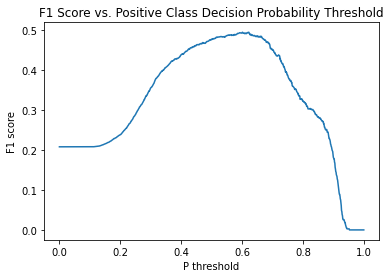

In [123]:
thresh_ps = np.linspace(0,1,1000)
model_val_probs = rf_model.predict_proba(scaled_xtest)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('rf Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best Threshold=0.621385, F-Score=0.495
recall:0.5418848167539267


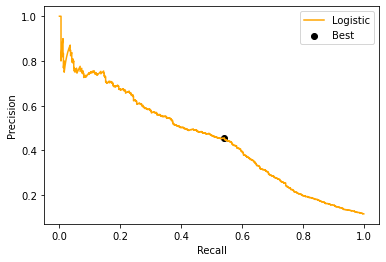

In [124]:
yhat = rf_model.predict_proba(scaled_xtest)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_val, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print(f'recall:{recall[ix]}' )
# plot the roc curve for the model
plt.plot(recall, precision, color='orange', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

### Ada

0.7819095613992519
classification_report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      5826
           1       0.28      0.70      0.40       764

    accuracy                           0.76      6590
   macro avg       0.62      0.73      0.63      6590
weighted avg       0.87      0.76      0.80      6590



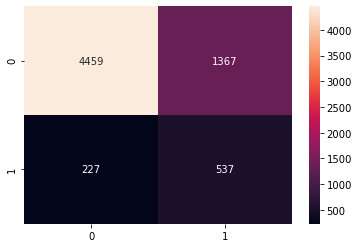

In [120]:
ada_model=AdaBoostClassifier(learning_rate=0.05,n_estimators=25)
ada_model.fit(scaled_xtrain, y_train_res)
    
y_predict_proba = ada_model.predict_proba(scaled_xtest)[:,1]
y_predict = ada_model.predict(scaled_xtest)
auc = roc_auc_score(y_val, y_predict_proba)
    
print(auc)
print('classification_report:\n',classification_report(y_val,y_predict))
sns.heatmap(confusion_matrix(y_val, y_predict),annot=True,fmt='d')
plt.show()

Best Threshold=0.685094, F-Score=0.469
recall:0.49607329842931935


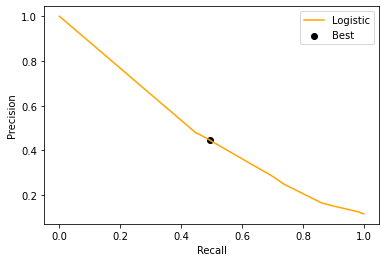

In [117]:
yhat = ada_model.predict_proba(scaled_xtest)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_val, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print(f'recall:{recall[ix]}' )
# plot the roc curve for the model
plt.plot(recall, precision, color='orange', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
model = fit(X,y) # fit model to training datset
probs = model.predict_proba(X_new) # prediction on a new dataset X_new

threshold = 0.7 # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = probs[:,1] # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

#### To be honest, we don't need adjust threshold since f1 in our current result is already close enough to the best f1 score, but we don't want to scarifice too much recall.

## 5. Pick the final model and read .feature_importances

final model: fit on train test on test

In [167]:
sm = SMOTE(random_state = 12)
X_train_res, y_train_res= sm.fit_sample(X_train, y_train)
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train_res)
scaled_xtrain = pd.DataFrame(scaled_xtrain, columns=list(X_train.columns))
scaled_xtest = scaler.transform(X_test)

AUC 0.7845483528480253
classification_report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      7328
           1       0.40      0.58      0.48       910

    accuracy                           0.86      8238
   macro avg       0.67      0.74      0.70      8238
weighted avg       0.89      0.86      0.87      8238



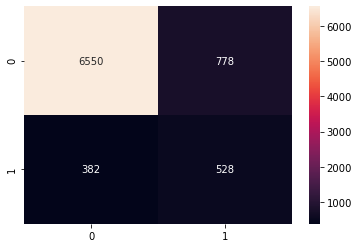

In [126]:
rf_model=RandomForestClassifier(max_features='log2',min_samples_leaf=150, n_estimators=500)
rf_model.fit(scaled_xtrain, y_train_res)
    
y_predict_proba = rf_model.predict_proba(scaled_xtest)[:,1]
y_predict = rf_model.predict(scaled_xtest)
auc = roc_auc_score(y_test, y_predict_proba)
    
print('AUC', auc)
print('classification_report:\n',classification_report(y_test,y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict),annot=True,fmt='d')
plt.show()

AUC 0.7645401200873363
classification_report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      7328
           1       0.27      0.67      0.38       910

    accuracy                           0.76      8238
   macro avg       0.61      0.72      0.61      8238
weighted avg       0.87      0.76      0.80      8238



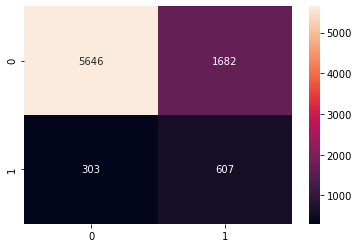

In [130]:
ada_model=ada_model=AdaBoostClassifier(learning_rate=0.05,n_estimators=25)
ada_model.fit(scaled_xtrain, y_train_res)
    
y_predict_proba = ada_model.predict_proba(scaled_xtest)[:,1]
y_predict = ada_model.predict(scaled_xtest)
auc = roc_auc_score(y_test, y_predict_proba)
    
print('AUC', auc)
print('classification_report:\n',classification_report(y_test,y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict),annot=True,fmt='d')
plt.show()

We can see here AdaBoost has 1682 false positive vs 778 in RF. 
Depends on the marketing budget, if the bank is eager to seize all positive subscriber, we'll go with AdaBoost. If the budget is limited, we can go with RandomForest.

In [83]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:20], y=fi_df['feature_names'][:20])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

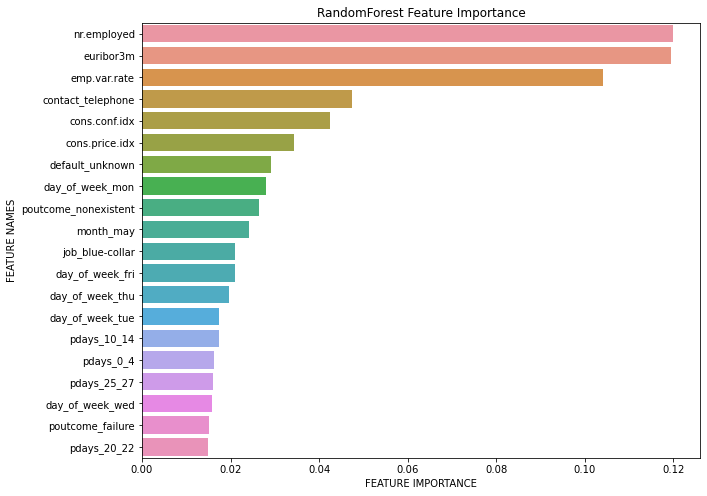

In [128]:
plot_feature_importance(rf_model.feature_importances_,X_train.columns,'RandomForest')

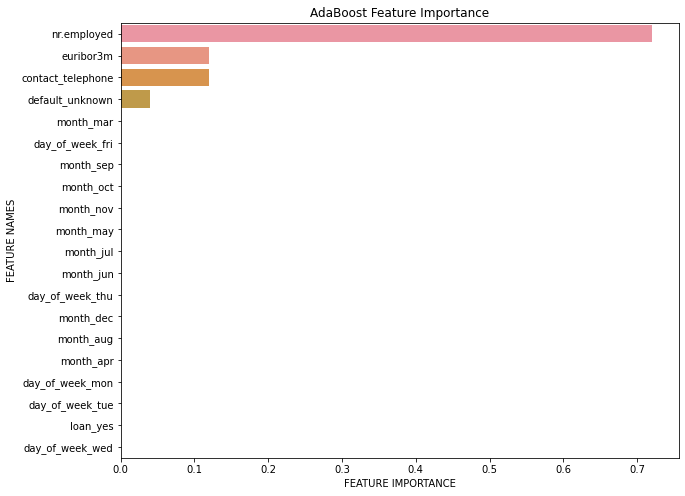

In [118]:
plot_feature_importance(ada_model.feature_importances_,X_train.columns,'AdaBoost')